In [129]:
import os
import mlflow
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

In [130]:
df = pd.read_pickle('../data/clean_data.pkl').sample(frac = 0.1, random_state = 2)
df.info()
#df.columns

<class 'pandas.core.frame.DataFrame'>
Index: 2285 entries, 1626 to 22026
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Date           2285 non-null   object  
 1   Gender         2285 non-null   category
 2   Annual Income  2285 non-null   float32 
 3   Dealer_Name    2285 non-null   category
 4   Company        2285 non-null   category
 5   Model          2285 non-null   category
 6   Color          2285 non-null   category
 7   Price ($)      2285 non-null   float32 
 8   Dealer_No      2285 non-null   object  
 9   Body Style     2285 non-null   category
 10  Dealer_Region  2285 non-null   category
 11  Config         2285 non-null   category
 12  Month          2285 non-null   int32   
 13  Year           2285 non-null   int32   
 14  Price/Income   2285 non-null   float32 
 15  norm_Income    2285 non-null   float32 
 16  norm_Price     2285 non-null   float32 
dtypes: category(8), float32(5), int32(

In [131]:
df = df.rename(columns={'Price ($)': 'target'})
df = df.drop(columns = ['Date', 'Month'])

In [132]:
df

,Gender,Annual Income,Dealer_Name,Company,Model,Color,target,Dealer_No,Body Style,Dealer_Region,Config,Year,Price/Income,norm_Income,norm_Price
1626,Male,900000.0,Iceberg Rentals,Mercury,Mercury Sable,Red,39000.0,53546-9427,Sedan,Janesville,DoubleÂ Overhead Camshaft Auto,2022,0.043333,0.079529,0.440191
723,Female,13500.0,Race Car Help,Toyota,Toyota Land Cruiser,Black,21000.0,78758-7841,SUV,Austin,DoubleÂ Overhead Camshaft Auto,2022,1.555556,0.000306,0.224880
19756,Female,620000.0,Clay Johnson Auto Sales,Dodge,Dodge Intrepid,Black,11001.0,78758-7841,Sedan,Austin,Overhead Camshaft Manual,2023,0.017744,0.054506,0.105275
20920,Male,13500.0,McKinney Dodge Chrysler Jeep,Audi,Audi A6,Pale White,24000.0,85257-3102,SUV,Scottsdale,Overhead Camshaft Manual,2023,1.777778,0.000306,0.260766
10420,Female,13500.0,New Castle Ford Lincoln Mercury,Nissan,Nissan Altima,Pale White,21001.0,60504-7114,Hatchback,Aurora,DoubleÂ Overhead Camshaft Auto,2022,1.555630,0.000306,0.224892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17526,Male,657500.0,Ryder Truck Rental and Leasing,Cadillac,Cadillac Eldorado,Black,29500.0,06457-3834,Passenger,Middletown,Overhead Camshaft Manual,2023,0.044867,0.057857,0.326555
10550,Male,903000.0,Suburban Ford,Lexus,Lexus LS400,Pale White,27001.0,53546-9427,Sedan,Janesville,DoubleÂ Overhead Camshaft Auto,2022,0.029901,0.079797,0.296663
6414,Male,981000.0,Saab-Belle Dodge,Saturn,Saturn LS,Pale White,51000.0,60504-7114,Sedan,Aurora,DoubleÂ Overhead Camshaft Auto,2022,0.051988,0.086767,0.583732
23086,Male,600000.0,Clay Johnson Auto Sales,Chrysler,Chrysler Cirrus,Red,12001.0,78758-7841,Passenger,Austin,DoubleÂ Overhead Camshaft Auto,2023,0.020002,0.052719,0.117237


In [133]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size = 0.25, random_state = 2)

In [134]:
cat_features = X_train.select_dtypes(include=['category', 'object']).columns.to_list()
cat_features

['Gender',
 'Dealer_Name',
 'Company',
 'Model',
 'Color',
 'Dealer_No ',
 'Body Style',
 'Dealer_Region',
 'Config']

In [135]:
num_features = X_train.select_dtypes(include = ['number']).columns.to_list()
num_features

['Annual Income', 'Year', 'Price/Income', 'norm_Income', 'norm_Price']

In [136]:
s_scaler = StandardScaler()
l_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=99999999)
regressor = CatBoostRegressor()

## Column transformer

In [137]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования

In [138]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor)])

pipeline.fit(X_train, y_train)

Learning rate set to 0.044577
0:	learn: 13809.1569915	total: 3.58ms	remaining: 3.58s
1:	learn: 13360.8881409	total: 10ms	remaining: 5s
2:	learn: 12884.1574913	total: 20ms	remaining: 6.64s
3:	learn: 12398.4071229	total: 20.8ms	remaining: 5.17s
4:	learn: 11960.2152363	total: 24.4ms	remaining: 4.86s
5:	learn: 11532.2484021	total: 30.1ms	remaining: 4.98s
6:	learn: 11096.6129748	total: 31ms	remaining: 4.39s
7:	learn: 10694.6695614	total: 38.9ms	remaining: 4.82s
8:	learn: 10311.4520848	total: 40.2ms	remaining: 4.42s
9:	learn: 9913.7881842	total: 45.2ms	remaining: 4.47s
10:	learn: 9558.4684907	total: 51.2ms	remaining: 4.61s
11:	learn: 9198.5806291	total: 53.2ms	remaining: 4.38s
12:	learn: 8879.2997198	total: 57.7ms	remaining: 4.38s
13:	learn: 8575.6318516	total: 60.5ms	remaining: 4.26s
14:	learn: 8270.4110308	total: 62.8ms	remaining: 4.13s
15:	learn: 7995.0992161	total: 70.8ms	remaining: 4.35s
16:	learn: 7693.9306953	total: 75ms	remaining: 4.33s
17:	learn: 7431.6369104	total: 76.1ms	remaining

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Annual Income', 'Year',
                                                   'Price/Income',
                                                   'norm_Income',
                                                   'norm_Price']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Gender', 'Dealer_Name',
                                                   'Company', 'Model', 'Color',
                                                   'Dealer_No ', 'Body Style',
                                                   'Dealer_Region',
                                                   'Config'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7bfc77716290>)])

In [139]:
predictions = pipeline.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 147.92809561161928,
 'mape': 0.005636038616034008,
 'mse': 186539.68771819372}

In [140]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri)   

In [141]:
EXPERIMENT_NAME = "estate_project"
RUN_NAME = "baseline model"
REGISTRY_MODEL_NAME = "estate_model_rf"

## Логирование

In [142]:
from mlflow.models import infer_signature

signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)

/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [143]:
req_file = '../requirements.txt'
art = '../comment.txt'

In [144]:
params_dict = pipeline.get_params()

In [145]:
# Когда создаем новый эксперимент, то: 
#experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

# Впоследствии. чтобы добавлять запуски в этот же эксепримент мы должны получить его id:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/21 01:34:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run baseline model at: http://127.0.0.1:5000/#/experiments/1/runs/b7c7e1febe624d15bbdffef65f2b72d3.
2024/11/21 01:34:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


## Удаление run, experiments

In [146]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
mlflow.search_runs(experiment_names=[EXPERIMENT_NAME],)


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mse,metrics.mape,metrics.mae,params.preprocessor__n_jobs,...,params.model__loss_function,params.steps,params.preprocessor__cat__max_categories,params.preprocessor__cat__dtype,params.preprocessor__cat__encoded_missing_value,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.name
0,b7c7e1febe624d15bbdffef65f2b72d3,1,FINISHED,mlflow-artifacts:/1/b7c7e1febe624d15bbdffef65f...,2024-11-20 22:34:50.599000+00:00,2024-11-20 22:34:51.045000+00:00,186539.687718,0.005636,147.928096,None,...,RMSE,"[('preprocessor', ColumnTransformer(transforme...",None,<class 'numpy.float64'>,nan,LOCAL,baseline model,"[{""run_id"": ""b7c7e1febe624d15bbdffef65f2b72d3""...",mainuser,/home/mainuser/my_proj/.venv_my_proj/lib/pytho...


## Автологирование

In [147]:
mlflow.sklearn.autolog()

with mlflow.start_run(run_name='auto', experiment_id=experiment_id) as run:
    pipeline.fit(X_train, y_train)

2024/11/21 01:34:51 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.1, but the installed version is 1.5.2. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2024/11/21 01:34:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever the

Learning rate set to 0.044577
0:	learn: 13809.1569915	total: 1.82ms	remaining: 1.81s
1:	learn: 13360.8881409	total: 2.96ms	remaining: 1.48s
2:	learn: 12884.1574913	total: 4.43ms	remaining: 1.47s
3:	learn: 12398.4071229	total: 5.65ms	remaining: 1.41s
4:	learn: 11960.2152363	total: 6.61ms	remaining: 1.31s
5:	learn: 11532.2484021	total: 7.59ms	remaining: 1.26s
6:	learn: 11096.6129748	total: 8.66ms	remaining: 1.23s
7:	learn: 10694.6695614	total: 9.85ms	remaining: 1.22s
8:	learn: 10311.4520848	total: 10.6ms	remaining: 1.17s
9:	learn: 9913.7881842	total: 11.4ms	remaining: 1.13s
10:	learn: 9558.4684907	total: 12.2ms	remaining: 1.1s
11:	learn: 9198.5806291	total: 14.6ms	remaining: 1.2s
12:	learn: 8879.2997198	total: 15.9ms	remaining: 1.21s
13:	learn: 8575.6318516	total: 17.2ms	remaining: 1.21s
14:	learn: 8270.4110308	total: 18.7ms	remaining: 1.23s
15:	learn: 7995.0992161	total: 20.2ms	remaining: 1.24s
16:	learn: 7693.9306953	total: 22.7ms	remaining: 1.31s
17:	learn: 7431.6369104	total: 27.3ms	

2024/11/21 01:34:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


957:	learn: 104.0720876	total: 893ms	remaining: 39.2ms
958:	learn: 103.9215219	total: 894ms	remaining: 38.2ms
959:	learn: 103.8607086	total: 895ms	remaining: 37.3ms
960:	learn: 103.7628120	total: 896ms	remaining: 36.4ms
961:	learn: 103.6571742	total: 897ms	remaining: 35.4ms
962:	learn: 103.5636502	total: 898ms	remaining: 34.5ms
963:	learn: 103.5098869	total: 898ms	remaining: 33.5ms
964:	learn: 103.4149727	total: 899ms	remaining: 32.6ms
965:	learn: 103.3615166	total: 900ms	remaining: 31.7ms
966:	learn: 103.2473476	total: 901ms	remaining: 30.7ms
967:	learn: 103.1696733	total: 901ms	remaining: 29.8ms
968:	learn: 103.0732755	total: 902ms	remaining: 28.9ms
969:	learn: 102.9725481	total: 903ms	remaining: 27.9ms
970:	learn: 102.8971243	total: 904ms	remaining: 27ms
971:	learn: 102.8001528	total: 905ms	remaining: 26.1ms
972:	learn: 102.7463777	total: 906ms	remaining: 25.1ms
973:	learn: 102.6060777	total: 907ms	remaining: 24.2ms
974:	learn: 102.5260846	total: 908ms	remaining: 23.3ms
975:	learn: 

2024/11/21 01:35:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run auto at: http://127.0.0.1:5000/#/experiments/1/runs/fb257b036c314125b32ffa3b9d2fccd8.
2024/11/21 01:35:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [148]:
mlflow.sklearn.autolog(disable=True)

## Model #2

In [149]:
regressor2 = RandomForestRegressor(n_estimators=10, max_depth=6)

In [150]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', regressor2)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Annual Income', 'Year',
                                                   'Price/Income',
                                                   'norm_Income',
                                                   'norm_Price']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Gender', 'Dealer_Name',
                                                   'Company', 'Model', 'Color',
                                                   'Dealer_No ', 'Body Style',
                                                   'Dealer_Region',
                                                   'Config'])])),
                ('model', RandomForestRegressor(max_depth=6, n_estimators=10))])

In [151]:
predictions = pipeline.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 58.24038369452652,
 'mape': 0.0028379334794348173,
 'mse': 11829.257796483278}

In [152]:
RUN_NAME = 'smaller_model'

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact(art)
    mlflow.log_params(pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/21 01:35:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run smaller_model at: http://127.0.0.1:5000/#/experiments/1/runs/568d8ac100344924b450beeac4672b58.
2024/11/21 01:35:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [153]:
RUN_NAME = 'no_model'
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id 
    mlflow.log_artifact(art)


run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/21 01:35:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run no_model at: http://127.0.0.1:5000/#/experiments/1/runs/51673895d2c7428abec037ccdeb166d8.
2024/11/21 01:35:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [154]:
model_reg = mlflow.search_registered_models()
model_reg[0]

<RegisteredModel: aliases={}, creation_timestamp=1731961042224, description='', last_updated_timestamp=1732139965206, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1732139965206, current_stage='None', description='', last_updated_timestamp=1732139965206, name='estate_model_rf', run_id='b12d9b11f7684540be412db26773c008', run_link='', source='mlflow-artifacts:/1/b12d9b11f7684540be412db26773c008/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='2'>], name='estate_model_rf', tags={}>

In [155]:
model_name = REGISTRY_MODEL_NAME
model_version = 1

model_loaded = mlflow.sklearn.load_model(model_uri=f"models:/{model_name}/{model_version}")

In [156]:
model_loaded.predict(X_test.iloc[0:1])

array([21001.])

In [157]:
y_test.iloc[0]

21001.0

# Feature engineering

## Sklearn

In [158]:
run_id = 'b12d9b11f7684540be412db26773c008' # Указываем run id
mlflow.register_model(f"runs:/{run_id}/models", REGISTRY_MODEL_NAME)

Registered model 'estate_model_rf' already exists. Creating a new version of this model...


2024/11/21 01:35:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: estate_model_rf, version 3
Created version '3' of model 'estate_model_rf'.


<ModelVersion: aliases=[], creation_timestamp=1732142102265, current_stage='None', description='', last_updated_timestamp=1732142102265, name='estate_model_rf', run_id='b12d9b11f7684540be412db26773c008', run_link='', source='mlflow-artifacts:/1/b12d9b11f7684540be412db26773c008/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='3'>

In [159]:
from sklearn.preprocessing import QuantileTransformer, SplineTransformer, PolynomialFeatures, MinMaxScaler, KBinsDiscretizer
from sklearn.linear_model import LogisticRegression

In [160]:
X_train_sklearn = X_train.copy()

In [161]:
num_features = ["Annual Income"]

In [162]:
transformers=[
    ('num', s_scaler, num_features), 
    ('cat', l_encoder, cat_features),
]

In [163]:
preprocessor = ColumnTransformer(transformers=transformers, remainder="passthrough")
X_train_sklearn = preprocessor.fit_transform(X_train_sklearn)

column_names = preprocessor.get_feature_names_out()
pd.DataFrame(column_names).to_csv("column_names.csv", index=False)  # Сохраняем в файл

X_transformed_df = pd.DataFrame(X_train_sklearn, columns=preprocessor.get_feature_names_out())


pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ('model', regressor)
])

In [164]:
model_sklearn = pipeline.fit(X_train, y_train)

Learning rate set to 0.044577
0:	learn: 13806.1961167	total: 7.22ms	remaining: 7.21s
1:	learn: 13304.9853396	total: 11.5ms	remaining: 5.71s
2:	learn: 12815.4455363	total: 14.1ms	remaining: 4.68s
3:	learn: 12362.6771331	total: 16.2ms	remaining: 4.04s
4:	learn: 11909.2465996	total: 22ms	remaining: 4.38s
5:	learn: 11453.6031437	total: 23.5ms	remaining: 3.9s
6:	learn: 11028.6545992	total: 26.1ms	remaining: 3.69s
7:	learn: 10635.4896421	total: 28.9ms	remaining: 3.58s
8:	learn: 10254.6211521	total: 32ms	remaining: 3.52s
9:	learn: 9887.3161172	total: 33.9ms	remaining: 3.36s
10:	learn: 9516.4891814	total: 37.3ms	remaining: 3.35s
11:	learn: 9155.2864857	total: 39.2ms	remaining: 3.23s
12:	learn: 8793.3524360	total: 42.7ms	remaining: 3.24s
13:	learn: 8462.6995620	total: 44.3ms	remaining: 3.12s
14:	learn: 8166.8697864	total: 46.7ms	remaining: 3.06s
15:	learn: 7875.9332345	total: 47.9ms	remaining: 2.95s
16:	learn: 7598.4324163	total: 48.9ms	remaining: 2.83s
17:	learn: 7325.9998066	total: 51.5ms	rem

In [165]:
model_sklearn

/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Annual Income']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Gender', 'Dealer_Name',
                                                   'Company', 'Model', 'Color',
                                                   'Dealer_No ', 'Body Style',
                                                   'Dealer_Region',
                                                   'Config'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7bfc77716290>)])

In [166]:
predictions = model_sklearn.predict(X_test) 
metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 139.59295204585806,
 'mape': 0.005192158592123233,
 'mse': 120052.73666910316}

In [167]:
RUN_NAME = 'fe_sklearn'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(model_sklearn, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact("column_names.csv", artifact_path="columns")
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/21 01:35:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run fe_sklearn at: http://127.0.0.1:5000/#/experiments/1/runs/1ce836b75cee48fa94b1734020584040.
2024/11/21 01:35:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [168]:
X_train.head(10)

,Gender,Annual Income,Dealer_Name,Company,Model,Color,Dealer_No,Body Style,Dealer_Region,Config,Year,Price/Income,norm_Income,norm_Price
12275,Male,13500.0,Enterprise Rent A Car,Mercury,Mercury Grand Marquis,Pale White,60504-7114,SUV,Aurora,Overhead Camshaft Manual,2023,1.185185,0.000306,0.165072
2786,Male,13500.0,Tri-State Mack Inc,Mercedes-B,Mercedes-B SL-Class,Pale White,85257-3102,SUV,Scottsdale,Overhead Camshaft Manual,2022,1.925926,0.000306,0.284689
21429,Male,13500.0,Progressive Shippers Cooperative Association No,Oldsmobile,Oldsmobile Silhouette,Pale White,53546-9427,Sedan,Janesville,Overhead Camshaft Manual,2023,2.518593,0.000306,0.380395
18593,Male,5500000.0,Tri-State Mack Inc,Audi,Audi A6,Black,85257-3102,SUV,Greenville,Overhead Camshaft Manual,2023,0.004545,0.490613,0.272727
22446,Female,425000.0,Scrivener Performance Engineering,Mitsubishi,Mitsubishi Montero Sport,Red,38701-8047,Hardtop,Austin,DoubleÂ Overhead Camshaft Auto,2023,0.091765,0.037080,0.440191
21501,Female,13500.0,Suburban Ford,Ford,Ford Crown Victoria,Pale White,53546-9427,Passenger,Janesville,DoubleÂ Overhead Camshaft Auto,2023,2.148148,0.000306,0.320574
7122,Female,1150000.0,McKinney Dodge Chrysler Jeep,Pontiac,Pontiac Sunfire,Red,85257-3102,Sedan,Scottsdale,Overhead Camshaft Manual,2022,0.037391,0.101870,0.488038
20537,Male,13500.0,Suburban Ford,Dodge,Dodge Ram Wagon,Black,53546-9427,Passenger,Janesville,DoubleÂ Overhead Camshaft Auto,2023,1.629630,0.000306,0.236842
23684,Male,985500.0,Chrysler Plymouth,Jeep,Jeep Grand Cherokee,Pale White,53546-9427,SUV,Janesville,Overhead Camshaft Manual,2023,0.015728,0.087170,0.159091
19204,Male,830000.0,Suburban Ford,Volvo,Volvo C70,Pale White,53546-9427,Hatchback,Janesville,Overhead Camshaft Manual,2023,0.028916,0.073273,0.260766


In [169]:
X_transformed_df.head(10)

,num__Annual Income,cat__Gender,cat__Dealer_Name,cat__Company,cat__Model,cat__Color,cat__Dealer_No,cat__Body Style,cat__Dealer_Region,cat__Config,remainder__Year,remainder__Price/Income,remainder__norm_Income,remainder__norm_Price
0,-1.184533,1.0,8.0,17.0,86.0,1.0,3.0,3.0,0.0,1.0,2023.0,1.185185,0.000306,0.165072
1,-1.184533,1.0,26.0,16.0,82.0,1.0,5.0,3.0,6.0,1.0,2022.0,1.925926,0.000306,0.284689
2,-1.184533,1.0,18.0,20.0,109.0,1.0,2.0,4.0,3.0,1.0,2023.0,2.518593,0.000306,0.380395
3,6.386611,1.0,26.0,1.0,4.0,0.0,5.0,3.0,2.0,1.0,2023.0,0.004545,0.490613,0.272727
4,-0.616680,0.0,23.0,18.0,97.0,2.0,1.0,0.0,1.0,0.0,2023.0,0.091765,0.037080,0.440191
5,-1.184533,0.0,25.0,8.0,45.0,1.0,2.0,2.0,3.0,0.0,2023.0,2.148148,0.000306,0.320574
6,0.383790,0.0,12.0,22.0,118.0,2.0,5.0,4.0,6.0,1.0,2022.0,0.037391,0.101870,0.488038
7,-1.184533,1.0,25.0,7.0,41.0,0.0,2.0,2.0,3.0,0.0,2023.0,1.629630,0.000306,0.236842
8,0.156787,1.0,3.0,13.0,66.0,1.0,2.0,3.0,3.0,1.0,2023.0,0.015728,0.087170,0.159091
9,-0.057797,1.0,25.0,29.0,146.0,1.0,2.0,1.0,3.0,1.0,2023.0,0.028916,0.073273,0.260766


In [170]:
from mlxtend.feature_selection import SequentialFeatureSelector 

In [171]:
sfs = SequentialFeatureSelector(RandomForestRegressor(n_estimators=3), 
                                k_features=3,
                                forward=True,
                                floating=False, # True to drop selected features
                                scoring='neg_mean_absolute_error',
                                cv=2)

sfs.fit(X_transformed_df,y_train)

/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mainuser/my_proj/.venv_my_

SequentialFeatureSelector(cv=2, estimator=RandomForestRegressor(n_estimators=3),
                          k_features=(3, 3), scoring='neg_mean_absolute_error')

In [172]:
selected_features_sfs = X_transformed_df.loc[:, sfs.k_feature_names_]
selected_features_sfs

,cat__Gender,remainder__Year,remainder__norm_Price
0,1.0,2023.0,0.165072
1,1.0,2022.0,0.284689
2,1.0,2023.0,0.380395
3,1.0,2023.0,0.272727
4,0.0,2023.0,0.440191
...,...,...,...
1708,1.0,2022.0,0.350478
1709,1.0,2022.0,0.296651
1710,1.0,2023.0,0.117225
1711,1.0,2023.0,0.180622


In [173]:
rfe_sfs_idx = list(sfs.k_feature_idx_)
rfe_sfs_idx
rfe_sfs_col = list(sfs.k_feature_names_)
rfe_sfs_col

['cat__Gender', 'remainder__Year', 'remainder__norm_Price']

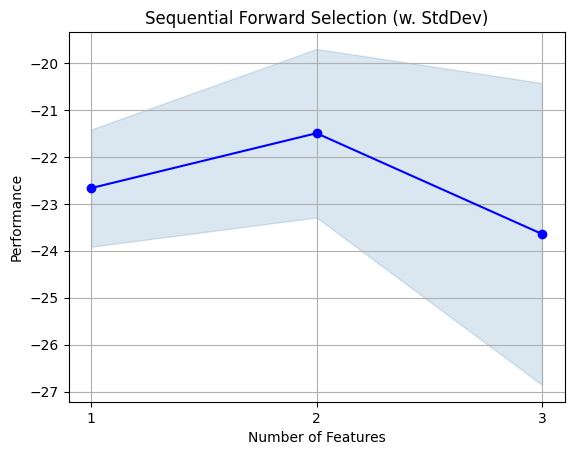

In [174]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [175]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X[:,self.cols]
    
    def fit(self, X, y=None):
        return self

In [176]:
rfe_sfs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', regressor)
])

rfe_sfs_pipeline.fit(X_train, y_train)

Learning rate set to 0.044577
0:	learn: 13784.7367592	total: 1.6ms	remaining: 1.6s
1:	learn: 13267.7920913	total: 2.17ms	remaining: 1.08s
2:	learn: 12751.8356535	total: 2.51ms	remaining: 834ms
3:	learn: 12256.0946476	total: 3ms	remaining: 748ms
4:	learn: 11782.0829863	total: 3.35ms	remaining: 668ms
5:	learn: 11336.0373543	total: 6.27ms	remaining: 1.04s
6:	learn: 10893.2090935	total: 6.84ms	remaining: 971ms
7:	learn: 10465.3992625	total: 7.5ms	remaining: 931ms
8:	learn: 10039.6767808	total: 9.37ms	remaining: 1.03s
9:	learn: 9647.2887697	total: 9.96ms	remaining: 986ms
10:	learn: 9254.9482065	total: 10.4ms	remaining: 936ms
11:	learn: 8927.4890231	total: 10.9ms	remaining: 897ms
12:	learn: 8559.9140944	total: 11.4ms	remaining: 863ms
13:	learn: 8243.2858333	total: 12.9ms	remaining: 911ms
14:	learn: 7906.7906412	total: 13.4ms	remaining: 883ms
15:	learn: 7602.9345382	total: 13.9ms	remaining: 854ms
16:	learn: 7320.6542383	total: 14.4ms	remaining: 832ms
17:	learn: 7036.5150018	total: 14.8ms	rema

/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Annual Income']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Gender', 'Dealer_Name',
                                                   'Company', 'Model', 'Color',
                                                   'Dealer_No ', 'Body Style',
                                                   'Dealer_Region',
                                                   'Config'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x7bfc76df99f0>),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7bfc77716290>)])

In [177]:
predictions_sfs = rfe_sfs_pipeline.predict(X_test)

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions_sfs)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions_sfs)
metrics["mse"] = mean_squared_error(y_test, predictions_sfs)

metrics


{'mae': 45.70201885359653,
 'mape': 0.0020127947551301746,
 'mse': 4900.805651885054}

In [178]:
RUN_NAME = 'SFS'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_sfs_col.txt')
    mlflow.log_artifact('rfe_sfs_idx.txt')
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/21 01:35:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run SFS at: http://127.0.0.1:5000/#/experiments/1/runs/b31ff765cfa94f8ca0306b6929b66f4c.
2024/11/21 01:35:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


## Optuna

In [179]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import mlflow

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    opt_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features))
    ])
    
    opt_pipeline.fit(X_train, y_train)

    preds = opt_pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-11-21 01:35:07,042] A new study created in memory with name: no-name-5fdf5e1b-96d3-459f-9ba1-1ca7bbec3d29
[I 2024-11-21 01:35:07,283] Trial 0 finished with value: 1163.805350809613 and parameters: {'n_estimators': 58, 'max_depth': 6, 'max_features': 0.39013437294132713}. Best is trial 0 with value: 1163.805350809613.
[I 2024-11-21 01:35:08,584] Trial 1 finished with value: 297.236916207293 and parameters: {'n_estimators': 290, 'max_depth': 7, 'max_features': 0.5952611684150535}. Best is trial 1 with value: 297.236916207293.
[I 2024-11-21 01:35:10,189] Trial 2 finished with value: 123.16779037695372 and parameters: {'n_estimators': 251, 'max_depth': 20, 'max_features': 0.6408728064797361}. Best is trial 2 with value: 123.16779037695372.
[I 2024-11-21 01:35:11,203] Trial 3 finished with value: 22.567783856956893 and parameters: {'n_estimators': 139, 'max_depth': 8, 'max_features': 0.984397907067332}. Best is trial 3 with value: 22.567783856956893.
[I 2024-11-21 01:35:12,338] Tria

Number of finished trials: 10
Best trial: {'n_estimators': 212, 'max_depth': 9, 'max_features': 0.9559903777694087}


In [180]:
best_params = study.best_trial.params
opt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(**best_params))
])

opt_pipeline.fit(X_train, y_train)

/home/mainuser/my_proj/.venv_my_proj/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Annual Income']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=99999999),
                                                  ['Gender', 'Dealer_Name',
                                                   'Company', 'Model', 'Color',
                                                   'Dealer_No ', 'Body Style',
                                                   'Dealer_Region',
                                                   'Config'])])),
                ('model',
                 RandomForestRegressor(max_depth=9,
                                       max_features=0.9559903777694087,
                                       n_estimators=212))])

In [181]:
predictions = opt_pipeline.predict(X_test) 

metrics = {}
metrics["mae"] = mean_absolute_error(y_test, predictions)   
metrics["mape"] = mean_absolute_percentage_error(y_test, predictions)
metrics["mse"] = mean_squared_error(y_test, predictions)

metrics

{'mae': 20.943164913727237,
 'mape': 0.0007523964400075133,
 'mse': 6135.125123183611}

In [182]:
RUN_NAME = 'optuna_model'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(opt_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/21 01:35:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run optuna_model at: http://127.0.0.1:5000/#/experiments/1/runs/58207c8f69904d6fa6dac49f99f9d963.
2024/11/21 01:35:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [183]:
X_all = pd.concat([X_train, X_test], axis=0)
y_all = pd.concat([y_train, y_test], axis=0)

In [184]:
X_train_sklearn = X_all.copy()

In [185]:

numeric_features = ["Annual Income"]

transformers=[
    ('num', s_scaler, num_features),
    ('cat', l_encoder, cat_features),
]
if numeric_features:
    transformers.append(
        ("poly", Pipeline([
            ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
            ("scaler", StandardScaler())
        ]), numeric_features)
    )


In [186]:
preprocessor = ColumnTransformer(transformers=transformers, remainder="passthrough")
X_train_fe_sklearn = preprocessor.fit_transform(X_train_sklearn)
column_names = preprocessor.get_feature_names_out()
pd.DataFrame(column_names).to_csv("column_names_final.csv", index=False)



X_transformed_df = pd.DataFrame(X_train_fe_sklearn, columns=preprocessor.get_feature_names_out())


pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ('model', regressor)
])

In [187]:
final_model = pipeline.fit(X_all, y_all)

Learning rate set to 0.046653
0:	learn: 13422.3039698	total: 1.38ms	remaining: 1.37s
1:	learn: 12899.0536325	total: 4.56ms	remaining: 2.27s
2:	learn: 12368.2344204	total: 7.53ms	remaining: 2.5s
3:	learn: 11879.5394339	total: 9.4ms	remaining: 2.34s
4:	learn: 11391.0533364	total: 12.5ms	remaining: 2.5s
5:	learn: 10948.9702304	total: 14.8ms	remaining: 2.45s
6:	learn: 10525.9020733	total: 17.3ms	remaining: 2.45s
7:	learn: 10116.5099731	total: 20.3ms	remaining: 2.51s
8:	learn: 9713.2832818	total: 22.8ms	remaining: 2.5s
9:	learn: 9316.5102376	total: 26.3ms	remaining: 2.6s
10:	learn: 8957.1259298	total: 30.1ms	remaining: 2.7s
11:	learn: 8618.6565202	total: 32.8ms	remaining: 2.7s
12:	learn: 8278.3883733	total: 35.1ms	remaining: 2.67s
13:	learn: 7955.9128691	total: 37.5ms	remaining: 2.64s
14:	learn: 7634.9171224	total: 39.8ms	remaining: 2.61s
15:	learn: 7337.7161535	total: 42.3ms	remaining: 2.6s
16:	learn: 7043.0265918	total: 45.6ms	remaining: 2.64s
17:	learn: 6767.2385352	total: 48.2ms	remaini

In [188]:
input_example = X_all.head(5)
RUN_NAME = 'final_model'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
        run_id = run.info.run_id 
        mlflow.sklearn.log_model(pipeline, 
                                    artifact_path="models",
                                    signature=signature,
                                    input_example=input_example,
                                    pip_requirements=req_file
                                )
        mlflow.log_params(model_sklearn.get_params())
        mlflow.log_artifact("column_names_final.csv", artifact_path="columns")
        
run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/21 01:35:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run final_model at: http://127.0.0.1:5000/#/experiments/1/runs/e1a340ce216d4188a24460ee16252dc2.
2024/11/21 01:35:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [189]:
X_train

,Gender,Annual Income,Dealer_Name,Company,Model,Color,Dealer_No,Body Style,Dealer_Region,Config,Year,Price/Income,norm_Income,norm_Price
12275,Male,13500.0,Enterprise Rent A Car,Mercury,Mercury Grand Marquis,Pale White,60504-7114,SUV,Aurora,Overhead Camshaft Manual,2023,1.185185,0.000306,0.165072
2786,Male,13500.0,Tri-State Mack Inc,Mercedes-B,Mercedes-B SL-Class,Pale White,85257-3102,SUV,Scottsdale,Overhead Camshaft Manual,2022,1.925926,0.000306,0.284689
21429,Male,13500.0,Progressive Shippers Cooperative Association No,Oldsmobile,Oldsmobile Silhouette,Pale White,53546-9427,Sedan,Janesville,Overhead Camshaft Manual,2023,2.518593,0.000306,0.380395
18593,Male,5500000.0,Tri-State Mack Inc,Audi,Audi A6,Black,85257-3102,SUV,Greenville,Overhead Camshaft Manual,2023,0.004545,0.490613,0.272727
22446,Female,425000.0,Scrivener Performance Engineering,Mitsubishi,Mitsubishi Montero Sport,Red,38701-8047,Hardtop,Austin,DoubleÂ Overhead Camshaft Auto,2023,0.091765,0.037080,0.440191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4681,Male,813500.0,Rabun Used Car Sales,Acura,Acura RL,Red,85257-3102,SUV,Scottsdale,Overhead Camshaft Manual,2022,0.038722,0.071799,0.350478
10580,Male,830000.0,Nebo Chevrolet,Lincoln,Lincoln Continental,Pale White,06457-3834,Passenger,Middletown,Overhead Camshaft Manual,2022,0.032530,0.073273,0.296651
23858,Male,1860000.0,Nebo Chevrolet,Audi,Audi A4,Pale White,06457-3834,Hardtop,Greenville,Overhead Camshaft Manual,2023,0.006452,0.165320,0.117225
19609,Male,1343000.0,U-Haul CO,Chevrolet,Chevrolet Monte Carlo,Red,78758-7841,Hatchback,Austin,Overhead Camshaft Manual,2023,0.012882,0.119118,0.180622
